# HPT PyTorch Lightning Transformer: Diabetes

In this tutorial, we will show how `spotPython` can be integrated into the `PyTorch` Lightning
training workflow for a regression task.

This chapter describes the hyperparameter tuning of a `PyTorch Lightning` network on the Diabetes data set. This is a PyTorch Dataset for regression. A toy data set from scikit-learn. Ten baseline variables, age, sex, body mass index, average blood pressure, and six blood serum measurements were obtained for each of n = 442 diabetes patients,  as well as the response of interest, a quantitative measure of disease progression one year after baseline.


## Step 1: Setup {#sec-setup-31}

* Before we consider the detailed experimental setup, we select the parameters that affect run time, initial design size, etc. 
* The parameter `MAX_TIME` specifies the maximum run time in seconds.
* The parameter `INIT_SIZE` specifies the initial design size.
* The parameter `WORKERS` specifies the number of workers. 
* The prefix `PREFIX` is used for the experiment name and the name of the log file.
* The parameter `DEVICE` specifies the device to use for training.


In [1]:
from spotPython.utils.device import getDevice
from math import inf

MAX_TIME = 1
FUN_EVALS = inf
INIT_SIZE = 10
WORKERS = 0
PREFIX="035"
DEVICE = getDevice()
DEVICES = 1
TEST_SIZE = 0.3

::: {.callout-caution}
### Caution: Run time and initial design size should be increased for real experiments

* `MAX_TIME` is set to one minute for demonstration purposes. For real experiments, this should be increased to at least 1 hour.
* `INIT_SIZE` is set to 5 for demonstration purposes. For real experiments, this should be increased to at least 10.
* `WORKERS` is set to 0 for demonstration purposes. For real experiments, this should be increased. See the warnings that are printed when the number of workers is set to 0.

:::

::: {.callout-note}
### Note: Device selection

* Although there are no .cuda() or .to(device) calls required, because Lightning does these for you, see 
[LIGHTNINGMODULE](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html), we would like to know which device is used. Threrefore, we imitate the LightningModule behaviour which selects the highest device. 
* The method `spotPython.utils.device.getDevice()` returns the device that is used by Lightning.
:::


## Step 2: Initialization of the `fun_control` Dictionary

`spotPython` uses a Python dictionary for storing the information required for the hyperparameter tuning process.


In [2]:
from spotPython.utils.init import fun_control_init
import numpy as np
fun_control = fun_control_init(
    _L_in=10,
    _L_out=1,
    PREFIX=PREFIX,
    TENSORBOARD_CLEAN=True,
    device=DEVICE,
    enable_progress_bar=False,
    fun_evals=FUN_EVALS,
    log_level=10,
    max_time=MAX_TIME,
    num_workers=WORKERS,
    show_progress=True,
    test_size=TEST_SIZE,
    tolerance_x=np.sqrt(np.spacing(1)),
    )

Seed set to 123


Moving TENSORBOARD_PATH: runs/ to TENSORBOARD_PATH_OLD: runs_OLD/runs_2024_01_28_17_54_15
Created spot_tensorboard_path: runs/spot_logs/035_p040025_2024-01-28_17-54-15 for SummaryWriter()


## Step 3: Loading the Diabetes Data Set


In [3]:
from spotPython.hyperparameters.values import set_control_key_value
from spotPython.data.diabetes import Diabetes
dataset = Diabetes()
set_control_key_value(control_dict=fun_control,
                        key="data_set",
                        value=dataset,
                        replace=True)
print(len(dataset))

442


::: {.callout-note}
### Note: Data Set and Data Loader

* As shown below, a DataLoader from `torch.utils.data` can be used to check the data.


In [4]:
# Set batch size for DataLoader
batch_size = 5
# Create DataLoader
from torch.utils.data import DataLoader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Iterate over the data in the DataLoader
for batch in dataloader:
    inputs, targets = batch
    print(f"Batch Size: {inputs.size(0)}")
    print(f"Inputs Shape: {inputs.shape}")
    print(f"Targets Shape: {targets.shape}")
    print("---------------")
    print(f"Inputs: {inputs}")
    print(f"Targets: {targets}")
    break

Batch Size: 5
Inputs Shape: torch.Size([5, 10])
Targets Shape: torch.Size([5])
---------------
Inputs: tensor([[ 0.0381,  0.0507,  0.0617,  0.0219, -0.0442, -0.0348, -0.0434, -0.0026,
          0.0199, -0.0176],
        [-0.0019, -0.0446, -0.0515, -0.0263, -0.0084, -0.0192,  0.0744, -0.0395,
         -0.0683, -0.0922],
        [ 0.0853,  0.0507,  0.0445, -0.0057, -0.0456, -0.0342, -0.0324, -0.0026,
          0.0029, -0.0259],
        [-0.0891, -0.0446, -0.0116, -0.0367,  0.0122,  0.0250, -0.0360,  0.0343,
          0.0227, -0.0094],
        [ 0.0054, -0.0446, -0.0364,  0.0219,  0.0039,  0.0156,  0.0081, -0.0026,
         -0.0320, -0.0466]])
Targets: tensor([151.,  75., 141., 206., 135.])


:::
## Step 4: Preprocessing {#sec-preprocessing-31}

Preprocessing is handled by `Lightning` and `PyTorch`. It is described in the [LIGHTNINGDATAMODULE](https://lightning.ai/docs/pytorch/stable/data/datamodule.html) documentation. Here you can find information about the `transforms` methods.

## Step 5: Select the Core Model (`algorithm`) and `core_model_hyper_dict` {#sec-selection-of-the-algorithm-31}

`spotPython` includes the `NetLightRegression` class [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/light/netlightregression.py) for configurable neural networks. 
The class is imported here. It inherits from the class `Lightning.LightningModule`, which is the base class for all models in `Lightning`. `Lightning.LightningModule` is a subclass of `torch.nn.Module` and provides additional functionality for the training and testing of neural networks. The class `Lightning.LightningModule` is described in the [Lightning documentation](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html).

* Here we simply add the NN Model to the fun_control dictionary by calling the function `add_core_model_to_fun_control`:


In [5]:
from spotPython.light.regression.transformerlightregression import TransformerLightRegression
from spotPython.hyperdict.light_hyper_dict import LightHyperDict
from spotPython.hyperparameters.values import add_core_model_to_fun_control
add_core_model_to_fun_control(fun_control=fun_control,
                              core_model=TransformerLightRegression,
                              hyper_dict=LightHyperDict)

The hyperparameters of the model are specified in the `core_model_hyper_dict` dictionary [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/hyperdict/light_hyper_dict.json).



## Step 6: Modify `hyper_dict` Hyperparameters for the Selected Algorithm aka `core_model` {#sec-modification-of-hyperparameters-31}

 `spotPython` provides functions for modifying the hyperparameters, their bounds and factors as well as for activating and de-activating hyperparameters without re-compilation of the Python source code. 

::: {.callout-caution}
### Caution: Small number of epochs for demonstration purposes

* `epochs` and `patience` are set to small values for demonstration purposes. These values are too small for a real application.
* More resonable values are, e.g.:
  * `set_control_hyperparameter_value(fun_control, "epochs", [7, 9])` and
  * `set_control_hyperparameter_value(fun_control, "patience", [2, 7])`
:::


In [6]:
from spotPython.hyperparameters.values import set_control_hyperparameter_value

# set_control_hyperparameter_value(fun_control, "l1", [2, 3])
# set_control_hyperparameter_value(fun_control, "epochs", [5, 7])
# set_control_hyperparameter_value(fun_control, "batch_size", [3, 4])
# set_control_hyperparameter_value(fun_control, "optimizer", [
#                 "Adadelta",
#                 "Adagrad",
#                 "Adam",
#                 "Adamax",                
#             ])
# set_control_hyperparameter_value(fun_control, "dropout_prob", [0.01, 0.1])
# set_control_hyperparameter_value(fun_control, "lr_mult", [0.5, 5.0])
# set_control_hyperparameter_value(fun_control, "patience", [3, 5])
# set_control_hyperparameter_value(fun_control, "act_fn",[
#                 "ReLU",
#                 "LeakyReLU",
#             ] )
set_control_hyperparameter_value(fun_control, "initialization",["Default"] )

Now, the dictionary `fun_control` contains all information needed for the hyperparameter tuning. Before the hyperparameter tuning is started, it is recommended to take a look at the experimental design. The method `gen_design_table` [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/utils/eda.py) generates a design table as follows:


In [7]:
#| fig-cap: Experimental design for the hyperparameter tuning.
from spotPython.utils.eda import gen_design_table
print(gen_design_table(fun_control))

| name            | type   | default   |   lower |   upper | transform             |
|-----------------|--------|-----------|---------|---------|-----------------------|
| d_mult          | int    | 1         |     0   |    4    | transform_power_2_int |
| l1              | int    | 3         |     3   |    8    | transform_power_2_int |
| dim_feedforward | int    | 3         |     2   |    4    | transform_power_2_int |
| nhead           | int    | 1         |     1   |    5    | transform_power_2_int |
| num_layers      | int    | 6         |     2   |   12    | None                  |
| epochs          | int    | 4         |     4   |    9    | transform_power_2_int |
| batch_size      | int    | 4         |     5   |   10    | transform_power_2_int |
| act_fn          | factor | Tanh      |     0   |    1    | None                  |
| optimizer       | factor | Adam      |     0   |    9    | None                  |
| dropout_prob    | float  | 0.01      |     0   |    0.25 | None

This allows to check if all information is available and if the information is correct.

::: {.callout-note}
### Note: Hyperparameters of the Tuned Model and the `fun_control` Dictionary
The updated `fun_control` dictionary can be shown with the command `fun_control["core_model_hyper_dict"]`.
:::


## Step 7: Data Splitting, the Objective (Loss) Function and the Metric

### Evaluation  {#sec-selection-of-target-function-31}

The evaluation procedure requires the specification of two elements:

1. the way how the data is split into a train and a test set
2. the loss function (and a metric).

::: {.callout-caution}
### Caution: Data Splitting in Lightning

The data splitting is handled by `Lightning`.

:::

### Loss Function {#sec-loss-function-31}

The loss function is specified in the configurable network class [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/light/regression/netlightregression.py)
We will use MSE.

### Metric {#sec-metric-31}

* Similar to the loss function, the metric is specified in the configurable network class [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/light/regression/netlightregression.py).

::: {.callout-caution}
### Caution: Loss Function and Metric in Lightning

* The loss function and the metric are not hyperparameters that can be tuned with `spotPython`.
* They are handled by `Lightning`.

:::


## Step 8: Calling the SPOT Function

### Preparing the SPOT Call {#sec-prepare-spot-call-31}


In [8]:
from spotPython.utils.init import design_control_init, surrogate_control_init
design_control = design_control_init(init_size=INIT_SIZE)

surrogate_control = surrogate_control_init(noise=True,
                                            n_theta=2)

::: {.callout-note}
### Note: Modifying Values in the Control Dictionaries 

* The values in the control dictionaries can be modified with the function `set_control_key_value` [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/hyperparameters/values.py), for example:



```{raw}
set_control_key_value(control_dict=surrogate_control,
                        key="noise",
                        value=True,
                        replace=True)                       
set_control_key_value(control_dict=surrogate_control,
                        key="n_theta",
                        value=2,
                        replace=True)      

```


:::

### The Objective Function `fun` {#sec-the-objective-function-31}

The objective function `fun` from the class `HyperLight` [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/fun/hyperlight.py) is selected next. It implements an interface from `PyTorch`'s training, validation, and testing methods to `spotPython`.


In [9]:
from spotPython.fun.hyperlight import HyperLight
fun = HyperLight(log_level=10).fun

### Showing the fun_control Dictionary {#sec-show-fun-control-31}


In [10]:
import pprint
pprint.pprint(fun_control)

{'CHECKPOINT_PATH': 'runs/saved_models/',
 'DATASET_PATH': 'data/',
 'PREFIX': '035',
 'RESULTS_PATH': 'results/',
 'TENSORBOARD_PATH': 'runs/',
 '_L_in': 10,
 '_L_out': 1,
 'accelerator': 'auto',
 'core_model': <class 'spotPython.light.regression.transformerlightregression.TransformerLightRegression'>,
 'core_model_hyper_dict': {'act_fn': {'class_name': 'spotPython.torch.activation',
                                      'core_model_parameter_type': 'instance()',
                                      'default': 'Tanh',
                                      'levels': ['Tanh', 'ReLU'],
                                      'lower': 0,
                                      'transform': 'None',
                                      'type': 'factor',
                                      'upper': 1},
                           'batch_size': {'default': 4,
                                          'lower': 5,
                                          'transform': 'transform_power_2_int',
  

### Starting the Hyperparameter Tuning {#sec-call-the-hyperparameter-tuner-31}

The `spotPython` hyperparameter tuning is started by calling the `Spot` function [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/spot/spot.py).


In [11]:
from spotPython.spot import spot
spot_tuner = spot.Spot(fun=fun,
                       fun_control=fun_control,
                       design_control=design_control,
                       surrogate_control=surrogate_control)
spot_tuner.run()

Seed set to 123


l_nodes: 8 must be divisible by nhead: 4 and 2.
layer_sizes: [80, 128, 64, 64, 32]
LightDataModule: setup(). stage: None
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit
LightDataModule: setup(). stage: test
LightDataModule: setup(). stage: predict
train_model(): Test set size: 133
train_model(): Train set size: 217
train_model(): Batch size: 64


/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'act_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['act_fn'])`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LightDataModule: setup(). stage: TrainerFn.FITTING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit



  | Name  | Type           | Params | In sizes | Out sizes
----------------------------------------------------------------
0 | model | TransformerNet | 29.7 K | [64, 10] | [64, 1]  
----------------------------------------------------------------
29.7 K    Trainable params
0         Non-trainable params
29.7 K    Total params
0.119     Total estimated model params size (MB)


LightDataModule: val_dataloader(). Training set size: 93
LightDataModule: val_dataloader(). batch_size: 64
LightDataModule: val_dataloader(). num_workers: 0


/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


LightDataModule: train_dataloader(). Training set size: 217
LightDataModule: train_dataloader(). batch_size: 64
LightDataModule: train_dataloader(). num_workers: 0


/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


LightDataModule: setup(). stage: TrainerFn.VALIDATING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: val_dataloader(). Training set size: 93
LightDataModule: val_dataloader(). batch_size: 64
LightDataModule: val_dataloader(). num_workers: 0


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │       30333.3359375       │
│         val_loss          │       30333.3359375       │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


train_model result: {'val_loss': 30333.3359375, 'hp_metric': 30333.3359375}
l_nodes: 128 must be divisible by nhead: 16 and 2.
layer_sizes: [1280, 64, 32, 32, 16]
LightDataModule: setup(). stage: None
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit
LightDataModule: setup(). stage: test
LightDataModule: setup(). stage: predict
train_model(): Test set size: 133
train_model(): Train set size: 217
train_model(): Batch size: 1024
LightDataModule: setup(). stage: TrainerFn.FITTING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit



  | Name  | Type           | Params | In sizes   | Out sizes
------------------------------------------------------------------
0 | model | TransformerNet | 866 K  | [1024, 10] | [1024, 1]
------------------------------------------------------------------
866 K     Trainable params
0         Non-trainable params
866 K     Total params
3.464     Total estimated model params size (MB)


LightDataModule: val_dataloader(). Training set size: 93
LightDataModule: val_dataloader(). batch_size: 1024
LightDataModule: val_dataloader(). num_workers: 0
LightDataModule: train_dataloader(). Training set size: 217
LightDataModule: train_dataloader(). batch_size: 1024
LightDataModule: train_dataloader(). num_workers: 0


/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
`Trainer.fit` stopped: `max_epochs=16` reached.


LightDataModule: setup(). stage: TrainerFn.VALIDATING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: val_dataloader(). Training set size: 93
LightDataModule: val_dataloader(). batch_size: 1024
LightDataModule: val_dataloader(). num_workers: 0


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │      29324.205078125      │
│         val_loss          │      29324.205078125      │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


train_model result: {'val_loss': 29324.205078125, 'hp_metric': 29324.205078125}
l_nodes: 512 must be divisible by nhead: 32 and 2.
layer_sizes: [5120, 128, 64, 64, 32]
LightDataModule: setup(). stage: None
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit
LightDataModule: setup(). stage: test
LightDataModule: setup(). stage: predict
train_model(): Test set size: 133
train_model(): Train set size: 217
train_model(): Batch size: 256
LightDataModule: setup(). stage: TrainerFn.FITTING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit



  | Name  | Type           | Params | In sizes  | Out sizes
-----------------------------------------------------------------
0 | model | TransformerNet | 8.2 M  | [256, 10] | [256, 1] 
-----------------------------------------------------------------
8.2 M     Trainable params
0         Non-trainable params
8.2 M     Total params
32.651    Total estimated model params size (MB)


LightDataModule: val_dataloader(). Training set size: 93
LightDataModule: val_dataloader(). batch_size: 256
LightDataModule: val_dataloader(). num_workers: 0
LightDataModule: train_dataloader(). Training set size: 217
LightDataModule: train_dataloader(). batch_size: 256
LightDataModule: train_dataloader(). num_workers: 0
LightDataModule: setup(). stage: TrainerFn.VALIDATING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: val_dataloader(). Training set size: 93
LightDataModule: val_dataloader(). batch_size: 256
LightDataModule: val_dataloader(). num_workers: 0


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │      7284.056640625       │
│         val_loss          │      7284.056640625       │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


train_model result: {'val_loss': 7284.056640625, 'hp_metric': 7284.056640625}
l_nodes: 128 must be divisible by nhead: 4 and 2.
layer_sizes: [1280, 16, 8, 8, 4]
LightDataModule: setup(). stage: None
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit
LightDataModule: setup(). stage: test
LightDataModule: setup(). stage: predict
train_model(): Test set size: 133
train_model(): Train set size: 217
train_model(): Batch size: 256
LightDataModule: setup(). stage: TrainerFn.FITTING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit



  | Name  | Type           | Params | In sizes  | Out sizes
-----------------------------------------------------------------
0 | model | TransformerNet | 503 K  | [256, 10] | [256, 1] 
-----------------------------------------------------------------
503 K     Trainable params
0         Non-trainable params
503 K     Total params
2.013     Total estimated model params size (MB)


LightDataModule: val_dataloader(). Training set size: 93
LightDataModule: val_dataloader(). batch_size: 256
LightDataModule: val_dataloader(). num_workers: 0
LightDataModule: train_dataloader(). Training set size: 217
LightDataModule: train_dataloader(). batch_size: 256
LightDataModule: train_dataloader(). num_workers: 0


`Trainer.fit` stopped: `max_epochs=32` reached.


LightDataModule: setup(). stage: TrainerFn.VALIDATING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: val_dataloader(). Training set size: 93
LightDataModule: val_dataloader(). batch_size: 256
LightDataModule: val_dataloader(). num_workers: 0


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │      28852.40234375       │
│         val_loss          │      28852.40234375       │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


train_model result: {'val_loss': 28852.40234375, 'hp_metric': 28852.40234375}
l_nodes: 128 must be divisible by nhead: 16 and 2.
layer_sizes: [1280, 64, 32, 32, 16]
LightDataModule: setup(). stage: None
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit
LightDataModule: setup(). stage: test
LightDataModule: setup(). stage: predict
train_model(): Test set size: 133
train_model(): Train set size: 217
train_model(): Batch size: 128
LightDataModule: setup(). stage: TrainerFn.FITTING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit



  | Name  | Type           | Params | In sizes  | Out sizes
-----------------------------------------------------------------
0 | model | TransformerNet | 370 K  | [128, 10] | [128, 1] 
-----------------------------------------------------------------
370 K     Trainable params
0         Non-trainable params
370 K     Total params
1.482     Total estimated model params size (MB)


LightDataModule: val_dataloader(). Training set size: 93
LightDataModule: val_dataloader(). batch_size: 128
LightDataModule: val_dataloader(). num_workers: 0
LightDataModule: train_dataloader(). Training set size: 217
LightDataModule: train_dataloader(). batch_size: 128
LightDataModule: train_dataloader(). num_workers: 0


/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


LightDataModule: setup(). stage: TrainerFn.VALIDATING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: val_dataloader(). Training set size: 93
LightDataModule: val_dataloader(). batch_size: 128
LightDataModule: val_dataloader(). num_workers: 0


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │      22126.88671875       │
│         val_loss          │      22126.88671875       │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


train_model result: {'val_loss': 22126.88671875, 'hp_metric': 22126.88671875}
l_nodes: 256 must be divisible by nhead: 16 and 2.
layer_sizes: [2560, 32, 16, 16, 8]
LightDataModule: setup(). stage: None
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit
LightDataModule: setup(). stage: test
LightDataModule: setup(). stage: predict
train_model(): Test set size: 133
train_model(): Train set size: 217
train_model(): Batch size: 512
LightDataModule: setup(). stage: TrainerFn.FITTING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit



  | Name  | Type           | Params | In sizes  | Out sizes
-----------------------------------------------------------------
0 | model | TransformerNet | 1.4 M  | [512, 10] | [512, 1] 
-----------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.672     Total estimated model params size (MB)


LightDataModule: val_dataloader(). Training set size: 93
LightDataModule: val_dataloader(). batch_size: 512
LightDataModule: val_dataloader(). num_workers: 0
LightDataModule: train_dataloader(). Training set size: 217
LightDataModule: train_dataloader(). batch_size: 512
LightDataModule: train_dataloader(). num_workers: 0
LightDataModule: setup(). stage: TrainerFn.VALIDATING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: val_dataloader(). Training set size: 93
LightDataModule: val_dataloader(). batch_size: 512
LightDataModule: val_dataloader(). num_workers: 0


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │      25586.435546875      │
│         val_loss          │      25586.435546875      │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


train_model result: {'val_loss': 25586.435546875, 'hp_metric': 25586.435546875}
l_nodes: 8 must be divisible by nhead: 2 and 2.
layer_sizes: [80, 8, 4, 4, 2]
LightDataModule: setup(). stage: None
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit
LightDataModule: setup(). stage: test
LightDataModule: setup(). stage: predict
train_model(): Test set size: 133
train_model(): Train set size: 217
train_model(): Batch size: 32
LightDataModule: setup(). stage: TrainerFn.FITTING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit



  | Name  | Type           | Params | In sizes | Out sizes
----------------------------------------------------------------
0 | model | TransformerNet | 5.5 K  | [32, 10] | [32, 1]  
----------------------------------------------------------------
5.5 K     Trainable params
0         Non-trainable params
5.5 K     Total params
0.022     Total estimated model params size (MB)


LightDataModule: val_dataloader(). Training set size: 93
LightDataModule: val_dataloader(). batch_size: 32
LightDataModule: val_dataloader(). num_workers: 0
LightDataModule: train_dataloader(). Training set size: 217
LightDataModule: train_dataloader(). batch_size: 32
LightDataModule: train_dataloader(). num_workers: 0


/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (7) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


LightDataModule: setup(). stage: TrainerFn.VALIDATING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: val_dataloader(). Training set size: 93
LightDataModule: val_dataloader(). batch_size: 32
LightDataModule: val_dataloader(). num_workers: 0


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     6730.52978515625      │
│         val_loss          │     6730.52978515625      │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


train_model result: {'val_loss': 6730.52978515625, 'hp_metric': 6730.52978515625}
l_nodes: 128 must be divisible by nhead: 8 and 2.
layer_sizes: [1280, 32, 16, 16, 8]
LightDataModule: setup(). stage: None
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit
LightDataModule: setup(). stage: test
LightDataModule: setup(). stage: predict
train_model(): Test set size: 133
train_model(): Train set size: 217
train_model(): Batch size: 64
LightDataModule: setup(). stage: TrainerFn.FITTING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit



  | Name  | Type           | Params | In sizes | Out sizes
----------------------------------------------------------------
0 | model | TransformerNet | 662 K  | [64, 10] | [64, 1]  
----------------------------------------------------------------
662 K     Trainable params
0         Non-trainable params
662 K     Total params
2.648     Total estimated model params size (MB)


LightDataModule: val_dataloader(). Training set size: 93
LightDataModule: val_dataloader(). batch_size: 64
LightDataModule: val_dataloader(). num_workers: 0
LightDataModule: train_dataloader(). Training set size: 217
LightDataModule: train_dataloader(). batch_size: 64
LightDataModule: train_dataloader(). num_workers: 0


`Trainer.fit` stopped: `max_epochs=64` reached.


LightDataModule: setup(). stage: TrainerFn.VALIDATING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: val_dataloader(). Training set size: 93
LightDataModule: val_dataloader(). batch_size: 64
LightDataModule: val_dataloader(). num_workers: 0


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │      31993.20703125       │
│         val_loss          │      31993.20703125       │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


train_model result: {'val_loss': 31993.20703125, 'hp_metric': 31993.20703125}
l_nodes: 32 must be divisible by nhead: 8 and 2.
layer_sizes: [320, 16, 8, 8, 4]
LightDataModule: setup(). stage: None
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit
LightDataModule: setup(). stage: test
LightDataModule: setup(). stage: predict
train_model(): Test set size: 133
train_model(): Train set size: 217
train_model(): Batch size: 128
LightDataModule: setup(). stage: TrainerFn.FITTING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit



  | Name  | Type           | Params | In sizes  | Out sizes
-----------------------------------------------------------------
0 | model | TransformerNet | 61.5 K | [128, 10] | [128, 1] 
-----------------------------------------------------------------
61.5 K    Trainable params
0         Non-trainable params
61.5 K    Total params
0.246     Total estimated model params size (MB)


LightDataModule: val_dataloader(). Training set size: 93
LightDataModule: val_dataloader(). batch_size: 128
LightDataModule: val_dataloader(). num_workers: 0
LightDataModule: train_dataloader(). Training set size: 217
LightDataModule: train_dataloader(). batch_size: 128
LightDataModule: train_dataloader(). num_workers: 0
LightDataModule: setup(). stage: TrainerFn.VALIDATING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: val_dataloader(). Training set size: 93
LightDataModule: val_dataloader(). batch_size: 128
LightDataModule: val_dataloader(). num_workers: 0


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     5690.33056640625      │
│         val_loss          │     5690.33056640625      │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


train_model result: {'val_loss': 5690.33056640625, 'hp_metric': 5690.33056640625}
l_nodes: 16 must be divisible by nhead: 4 and 2.
layer_sizes: [160, 256, 128, 128, 64]
LightDataModule: setup(). stage: None
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit
LightDataModule: setup(). stage: test
LightDataModule: setup(). stage: predict
train_model(): Test set size: 133
train_model(): Train set size: 217
train_model(): Batch size: 512
LightDataModule: setup(). stage: TrainerFn.FITTING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit



  | Name  | Type           | Params | In sizes  | Out sizes
-----------------------------------------------------------------
0 | model | TransformerNet | 108 K  | [512, 10] | [512, 1] 
-----------------------------------------------------------------
108 K     Trainable params
0         Non-trainable params
108 K     Total params
0.432     Total estimated model params size (MB)


LightDataModule: val_dataloader(). Training set size: 93
LightDataModule: val_dataloader(). batch_size: 512
LightDataModule: val_dataloader(). num_workers: 0
LightDataModule: train_dataloader(). Training set size: 217
LightDataModule: train_dataloader(). batch_size: 512
LightDataModule: train_dataloader(). num_workers: 0


`Trainer.fit` stopped: `max_epochs=32` reached.


LightDataModule: setup(). stage: TrainerFn.VALIDATING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: val_dataloader(). Training set size: 93
LightDataModule: val_dataloader(). batch_size: 512
LightDataModule: val_dataloader(). num_workers: 0


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     7629.31591796875      │
│         val_loss          │     7629.31591796875      │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 7629.31591796875, 'hp_metric': 7629.31591796875}


/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'act_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['act_fn'])`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type           | Params | In sizes  | Out sizes
-----------------------------------------------------------------
0 | model | TransformerNet | 61.5 K | [128, 10] | [128, 1] 
-----------------------------------------------------------------
61.5 K    Trainable params
0         Non-trainable params
61.5 K    Total params
0.246     Total estimated model params size (MB)


l_nodes: 32 must be divisible by nhead: 8 and 2.
layer_sizes: [320, 16, 8, 8, 4]
LightDataModule: setup(). stage: None
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit
LightDataModule: setup(). stage: test
LightDataModule: setup(). stage: predict
train_model(): Test set size: 133
train_model(): Train set size: 217
train_model(): Batch size: 128
LightDataModule: setup(). stage: TrainerFn.FITTING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit
LightDataModule: val_dataloader(). Training set size: 93
LightDataModule: val_dataloader(). batch_size: 128
LightDataModule: val_dataloader(). num_workers: 0
LightDataModule: train_dataloader(). Training set size: 217
LightDataModule: train_

/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


LightDataModule: setup(). stage: TrainerFn.VALIDATING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: val_dataloader(). Training set size: 93
LightDataModule: val_dataloader(). batch_size: 128
LightDataModule: val_dataloader(). num_workers: 0


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │      6376.7998046875      │
│         val_loss          │      6376.7998046875      │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 6376.7998046875, 'hp_metric': 6376.7998046875}
spotPython tuning: 5690.33056640625 [##########] 100.00% Done...



## Step 9: Tensorboard {#sec-tensorboard-31}

The textual output shown in the console (or code cell) can be visualized with Tensorboard.



```{raw}
tensorboard --logdir="runs/"
```



Further information can be found in the [PyTorch Lightning documentation](https://lightning.ai/docs/pytorch/stable/api/lightning.pytorch.loggers.tensorboard.html) for Tensorboard.



## Step 10: Results {#sec-results-31}

After the hyperparameter tuning run is finished, the results can be analyzed.


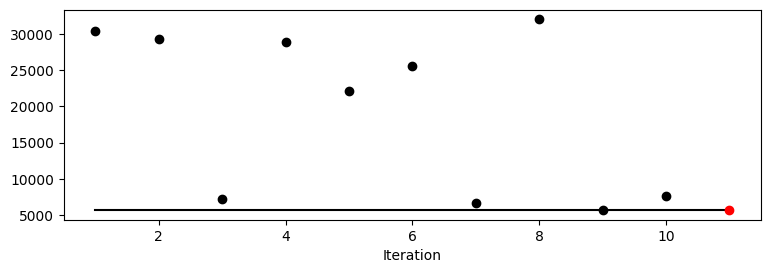

In [12]:
#| fig-cap: Progress plot. *Black* dots denote results from the initial design. *Red* dots  illustrate the improvement found by the surrogate model based optimization.
spot_tuner.plot_progress(log_y=False,
    filename="./figures/" + PREFIX +"_progress.png")

In [13]:
#| fig-cap: Results of the hyperparameter tuning.
from spotPython.utils.eda import gen_design_table
print(gen_design_table(fun_control=fun_control, spot=spot_tuner))

| name            | type   | default   |   lower |   upper | tuned              | transform             |   importance | stars   |
|-----------------|--------|-----------|---------|---------|--------------------|-----------------------|--------------|---------|
| d_mult          | int    | 1         |     0.0 |     4.0 | 1.0                | transform_power_2_int |        65.68 | **      |
| l1              | int    | 3         |     3.0 |     8.0 | 4.0                | transform_power_2_int |        57.95 | **      |
| dim_feedforward | int    | 3         |     2.0 |     4.0 | 2.0                | transform_power_2_int |        25.74 | *       |
| nhead           | int    | 1         |     1.0 |     5.0 | 3.0                | transform_power_2_int |         0.67 | .       |
| num_layers      | int    | 6         |     2.0 |    12.0 | 11.0               | None                  |       100.00 | ***     |
| epochs          | int    | 4         |     4.0 |     9.0 | 9.0                | t

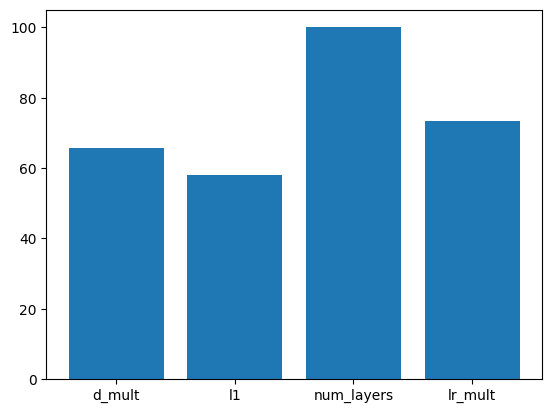

In [28]:
#| fig-cap: 'Variable importance plot, threshold 0.025.'
spot_tuner.plot_importance(threshold=50,
    filename="./figures/" + PREFIX + "_importance.png")

### Get the Tuned Architecture {#sec-get-spot-results-31}


In [15]:
from spotPython.hyperparameters.values import get_tuned_architecture
config = get_tuned_architecture(spot_tuner, fun_control)
print(config)

{'d_mult': 2, 'l1': 16, 'dim_feedforward': 4, 'nhead': 8, 'num_layers': 11, 'epochs': 512, 'batch_size': 128, 'act_fn': ReLU(), 'optimizer': 'Adamax', 'dropout_prob': 0.1339872515791855, 'lr_mult': 7.098231443884357, 'patience': 32, 'initialization': 'Default'}


* Test on the full data set


In [16]:
from spotPython.light.testmodel import test_model
test_model(config, fun_control)

/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'act_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['act_fn'])`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type           | Params | In sizes  | Out sizes
-----------------------------------------------------------------
0 | model | TransformerNet | 61.5 K | [128, 10] | [128, 1] 
-----------------------------------------------------------------
61.5 K    Trainable params
0         Non-trainable params
61.5 K    Total params
0.246     Total estimated model params size (MB)


LightDataModule: setup(). stage: None
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit
LightDataModule: setup(). stage: test
LightDataModule: setup(). stage: predict
l_nodes: 32 must be divisible by nhead: 8 and 2.
layer_sizes: [320, 16, 8, 8, 4]
LightDataModule: setup(). stage: TrainerFn.FITTING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit
LightDataModule: val_dataloader(). Training set size: 93
LightDataModule: val_dataloader(). batch_size: 128
LightDataModule: val_dataloader(). num_workers: 0
LightDataModule: train_dataloader(). Training set size: 217
LightDataModule: train_dataloader(). batch_size: 128
LightDataModule: train_dataloader(). num_workers: 0


/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
Restoring states from the checkpo

LightDataModule: setup(). stage: TrainerFn.TESTING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: test


Loaded model weights from the checkpoint at /Users/bartz/workspace/Hyperparameter-Tuning-Cookbook/runs/saved_models/2_16_4_8_11_512_128_ReLU_Adamax_0.134_7.0982_32_Default_TEST/last.ckpt
/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


LightDataModule: test_dataloader(). Test set size: 133
LightDataModule: test_dataloader(). batch_size: 128
LightDataModule: test_dataloader(). num_workers: 0


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │         6909.8125         │
│         val_loss          │         6909.8125         │
└───────────────────────────┴───────────────────────────┘

test_model result: {'val_loss': 6909.8125, 'hp_metric': 6909.8125}


(6909.8125, 6909.8125)

In [17]:
from spotPython.light.loadmodel import load_light_from_checkpoint

model_loaded = load_light_from_checkpoint(config, fun_control)

config: {'d_mult': 2, 'l1': 16, 'dim_feedforward': 4, 'nhead': 8, 'num_layers': 11, 'epochs': 512, 'batch_size': 128, 'act_fn': ReLU(), 'optimizer': 'Adamax', 'dropout_prob': 0.1339872515791855, 'lr_mult': 7.098231443884357, 'patience': 32, 'initialization': 'Default'}
Loading model with 2_16_4_8_11_512_128_ReLU_Adamax_0.134_7.0982_32_Default_TEST from runs/saved_models/2_16_4_8_11_512_128_ReLU_Adamax_0.134_7.0982_32_Default_TEST/last.ckpt
l_nodes: 32 must be divisible by nhead: 8 and 2.
layer_sizes: [320, 16, 8, 8, 4]
Model: TransformerLightRegression(
  (model): TransformerNet(
    (act_fn): ReLU()
    (embed): SkipLinear(
      (lst_modules): ModuleList(
        (0-9): 10 x Core()
      )
    )
    (pos_enc): PositionalEncoding(
      (dropout): Dropout(p=0.1339872515791855, inplace=False)
    )
    (enc_layer): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
      )
     

d_mult:  65.67670468608333
l1:  57.95491614895105
num_layers:  100.0
lr_mult:  73.45354935703678


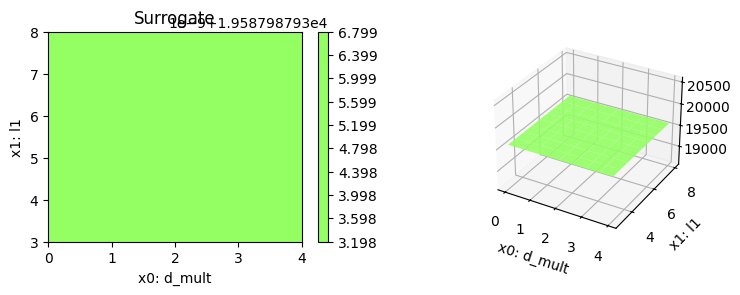

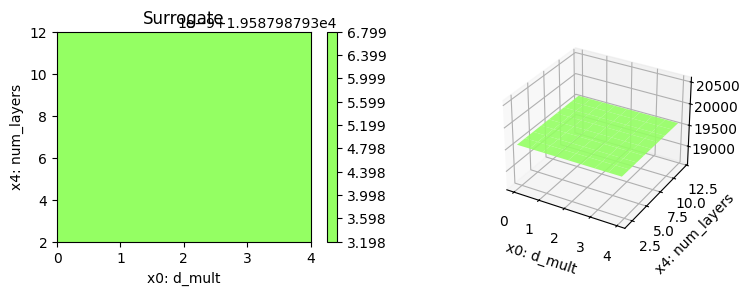

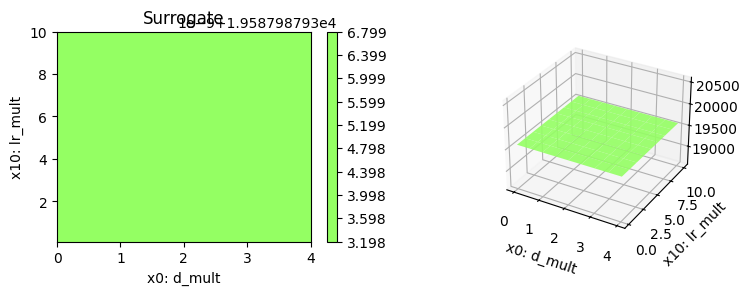

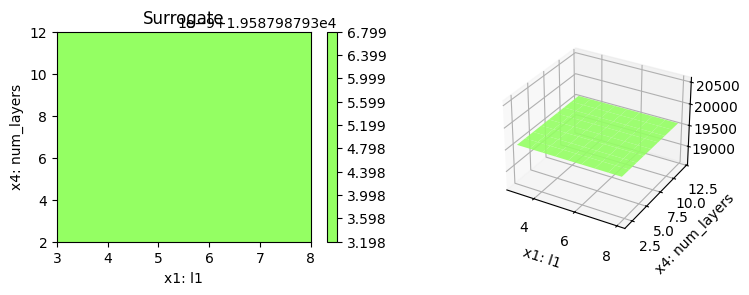

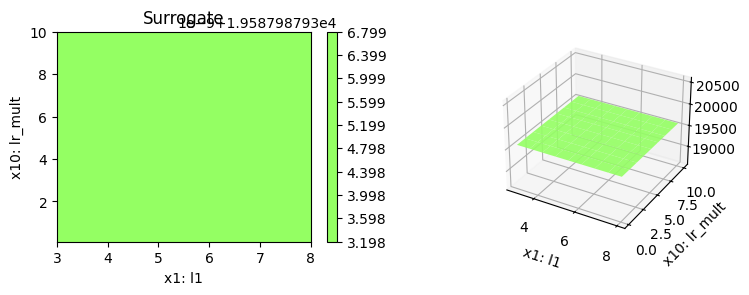

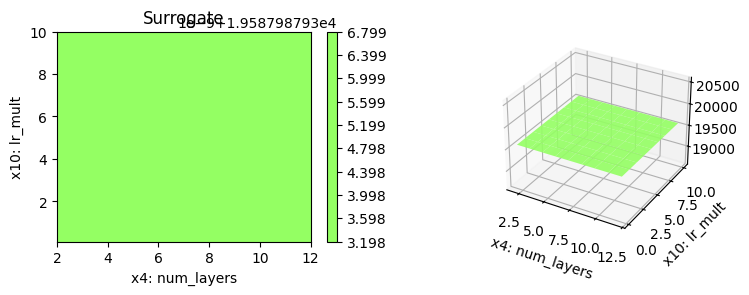

In [27]:
#| fig-cap: Contour plots.
# filename = "./figures/" + PREFIX
filename = None
spot_tuner.plot_important_hyperparameter_contour(filename=filename, threshold=50)

### Parallel Coordinates Plot


In [19]:
#| fig-cap: Parallel coordinates plots
spot_tuner.parallel_plot()

### Cross Validation With Lightning

* The `KFold` class from `sklearn.model_selection` is used to generate the folds for cross-validation.
* These mechanism is used to generate the folds for the final evaluation of the model.
* The `CrossValidationDataModule` class [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/data/lightcrossvalidationdatamodule.py) is used to generate the folds for the hyperparameter tuning process.
* It is called from the `cv_model` function [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/light/cvmodel.py).


In [20]:
from spotPython.light.cvmodel import cv_model
set_control_key_value(control_dict=fun_control,
                        key="k_folds",
                        value=2,
                        replace=True)
set_control_key_value(control_dict=fun_control,
                        key="test_size",
                        value=0.6,
                        replace=True)
cv_model(config, fun_control)

/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: UserWarning:

Attribute 'act_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['act_fn'])`.

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type           | Params | In sizes  | Out sizes
-----------------------------------------------------------------
0 | model | TransformerNet | 61.5 K | [128, 10] | [128, 1] 
-----------------------------------------------------------------
61.5 K    Trainable params
0         Non-trainable params
61.5 K    Total params
0.246     Total estimated model params size (MB)


k: 0
l_nodes: 32 must be divisible by nhead: 8 and 2.
layer_sizes: [320, 16, 8, 8, 4]
Train Dataset Size: 221
Val Dataset Size: 221


/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: PossibleUserWarning:

The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want t

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     6725.10009765625      │
│         val_loss          │     6725.10009765625      │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: UserWarning:

Checkpoint directory runs/lightning_logs/20240128180512648081_2_16_4_8_11_512_128_ReLU_Adamax_0.134_7.0982_32_Default_CV/checkpoints exists and is not empty.


  | Name  | Type           | Params | In sizes  | Out sizes
-----------------------------------------------------------------
0 | model | TransformerNet | 61.5 K | [128, 10] | [128, 1] 
-----------------------------------------------------------------
61.5 K    Trainable params
0         Non-trainable params
61.5 K    Total params
0.246     Total estimated model params size (MB)


train_model result: {'val_loss': 6725.10009765625, 'hp_metric': 6725.10009765625}
k: 1
l_nodes: 32 must be divisible by nhead: 8 and 2.
layer_sizes: [320, 16, 8, 8, 4]
Train Dataset Size: 221
Val Dataset Size: 221


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     5310.41748046875      │
│         val_loss          │     5310.41748046875      │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 5310.41748046875, 'hp_metric': 5310.41748046875}


6017.7587890625

### Plot all Combinations of Hyperparameters

* Warning: this may take a while.


In [21]:
PLOT_ALL = False
if PLOT_ALL:
    n = spot_tuner.k
    for i in range(n-1):
        for j in range(i+1, n):
            spot_tuner.plot_contour(i=i, j=j, min_z=min_z, max_z = max_z)

### Visualizing the Activation Distribution (Under Development)

::: {.callout-note}
### Reference:

* The following code is based on [[PyTorch Lightning TUTORIAL 2: ACTIVATION FUNCTIONS]](https://lightning.ai/docs/pytorch/stable/notebooks/course_UvA-DL/02-activation-functions.html), Author: Phillip Lippe, License: [[CC BY-SA]](https://creativecommons.org/licenses/by-sa/3.0/), Generated: 2023-03-15T09:52:39.179933.

:::

After we have trained the models, we can look at the actual activation values that find inside the model. For instance, how many neurons are set to zero in ReLU? Where do we find most values in Tanh? To answer these questions, we can write a simple function which takes a trained model, applies it to a batch of images, and plots the histogram of the activations inside the network:


In [22]:
from spotPython.torch.activation import Sigmoid, Tanh, ReLU, LeakyReLU, ELU, Swish
act_fn_by_name = {"sigmoid": Sigmoid, "tanh": Tanh, "relu": ReLU, "leakyrelu": LeakyReLU, "elu": ELU, "swish": Swish}

In [23]:
from spotPython.hyperparameters.values import get_one_config_from_X
X = spot_tuner.to_all_dim(spot_tuner.min_X.reshape(1,-1))
config = get_one_config_from_X(X, fun_control)
model = fun_control["core_model"](**config, _L_in=64, _L_out=11)
model

l_nodes: 32 must be divisible by nhead: 8 and 2.
layer_sizes: [2048, 16, 8, 8, 4]


TransformerLightRegression(
  (model): TransformerNet(
    (act_fn): ReLU()
    (embed): SkipLinear(
      (lst_modules): ModuleList(
        (0-63): 64 x Core()
      )
    )
    (pos_enc): PositionalEncoding(
      (dropout): Dropout(p=0.1339872515791855, inplace=False)
    )
    (enc_layer): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
      )
      (linear1): Linear(in_features=32, out_features=4, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=4, out_features=32, bias=True)
      (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
    (trans_enc): TransformerEncoder(
      (layers): ModuleList(
        (0-10): 11 x TransformerEncoderLayer(
      

In [24]:
# from spotPython.utils.eda import visualize_activations
# visualize_activations(model, color=f"C{0}")